In [1]:
!kaggle datasets download -d davi1990/example-fittingresults
!unzip example-fittingresults.zip
!rm example-fittingresults.zip


!kaggle datasets download -d davi1990/empirical-data
!unzip empirical-data.zip
!rm empirical-data.zip

# @title Download data

Dataset URL: https://www.kaggle.com/datasets/davi1990/example-fittingresults
License(s): MIT
100% 2.34G/2.35G [00:32<00:00, 139MB/s]
100% 2.35G/2.35G [00:33<00:00, 76.5MB/s]
Archive:  example-fittingresults.zip
  inflating: example-fittingresults.pkl  
Dataset URL: https://www.kaggle.com/datasets/davi1990/empirical-data
License(s): MIT
 99% 667M/675M [00:03<00:00, 196MB/s]
100% 675M/675M [00:03<00:00, 193MB/s]
Archive:  empirical-data.zip
  inflating: all_eeg_evoked.npy      
  inflating: all_epo_seeg.pkl        
  inflating: dist_Schaefer_1000parcels_7net.pkl  
  inflating: example_epoched.fif     


In [2]:
!git clone -b zheng_dev https://github.com/JohnWangDataAnalyst/whobpyt


# @title whobpyt Package

Cloning into 'whobpyt'...
remote: Enumerating objects: 3863, done.
remote: Counting objects: 100% (1571/1571), done.
remote: Compressing objects: 100% (560/560), done.
remote: Total 3863 (delta 1247), reused 1167 (delta 1011), pack-reused 2292
Receiving objects: 100% (3863/3863), 49.66 MiB | 33.34 MiB/s, done.
Resolving deltas: 100% (2146/2146), done.


In [3]:
import sys
!{sys.executable} -m pip install mne > /dev/null
!{sys.executable} -m pip install nilearn > /dev/null
!{sys.executable} -m pip install nibabel > /dev/null

# @title Install dependencies

In [22]:
path = 'whobpyt'

import os
import sys
sys.path.append(path)

import torch
import whobpyt
from whobpyt.datatypes import par, Recording
from whobpyt.data import dataloader
from whobpyt.models.JansenRit.jansen_rit_old import RNNJANSEN, ParamsJR
from whobpyt.optimization.custom_cost_JR import CostsJR
from whobpyt.run import Model_fitting

import numpy as np
import matplotlib.pyplot as plt # for plotting
import scipy.io
import pandas as pd
import nibabel as nib
import nibabel
import mne
import pickle

import warnings
warnings.filterwarnings('ignore')

# @title Importage

In [19]:
# URL of the CSV file containing centroid coordinates for Schaefer2018 atlas
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'

# Read the CSV file into a DataFrame
atlas = pd.read_csv(url)

# Extract the 'ROI Name' column from the DataFrame
label = atlas['ROI Name']

# Create a list to store stripped labels
label_stripped = []

# Strip '7Networks_' from each label and append to the list
for xx in range(len(label)):
    label_stripped.append(label[xx].replace('7Networks_', ''))

# Define the list of network names
networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']

# Create a dictionary to store the network indices
network_indices = {network: [] for network in networks}

# Iterate over each stripped label
for i, label in enumerate(label_stripped):
    # Iterate over each network
    for network in networks:
        if network in label:
            # Append the index to the corresponding network's list in the dictionary
            network_indices[network].append(i)
            break

# Define the stimulated network
sti_net = 'Default'

# Convert the list of indices for the stimulated network to a numpy array
network_indices_arr = np.array(network_indices[sti_net])

# Get the indices that do not belong to the stimulated network
diff = np.array(list(set(np.arange(200)) - set(network_indices_arr)))


In [20]:
#already trained file
fit_file = 'example-fittingresults.pkl'


# Define model parameters
state_lb=-0.2
state_ub=0.2
delays_max = 500
when_damage = 80
node_size = 200
batch_size = 20
step_size = 0.0001
pop_size=3
num_epochs = 150
tr = 0.001
state_size = 2
base_batch_num = 20
time_dim = 400
state_size = 2
base_batch_num = 100
hidden_size = int(tr/step_size)
TPperWindow=batch_size
node_size = 200
state_size = 2
transient_num = 10
pop_size = 3

transient_num = 10
final_ouput_P = []
final_ouput_E = []
final_ouput_I = []
final_ouput_eeg = []



Simulate the first 80ms (resting state)

In [21]:
# Initialize an empty dictionary to store lesion data
lesion_data = {}

# Load data from a pickle file
with open(fit_file, 'rb') as f:
    data = pickle.load(f)

# Initialize the state tensor x0 with random values uniformly distributed between state_lb and state_ub
x0 = torch.tensor(np.random.uniform(state_lb, state_ub,
              (data.model.node_size, pop_size, data.model.state_size)), dtype=torch.float32)

# Initialize the hemodynamic state tensor he0 with random values uniformly distributed between state_lb and state_ub
he0 = torch.tensor(np.random.uniform(state_lb, state_ub,
               (data.model.node_size, delays_max)), dtype=torch.float32)

# Create an input tensor u with zeros, with dimensions 200x10x80xpop_size
u = np.zeros((200, 10, when_damage, pop_size))

# Apply a stimulus of 2000 units to a specific time range (65-75ms) for the first population
u[:, :, 65:75, 0] = 2000

# Create a mask with ones of shape 200x200
mask = np.ones((200, 200))

# Assign the mask to the model's mask attribute
data.model.mask = mask

# Initialize data_mean with ones, with dimensions 1x8x(output_size)x(TRs_per_window)
data_mean = np.ones(([1, int(when_damage / TPperWindow), data.model.output_size, data.model.TRs_per_window]))

# Evaluate the model with the given input tensor u, empirical data data_mean, and initial states x0 and he0
data.evaluate(u=u, empRec=data_mean, TPperWindow=data.model.TRs_per_window, X=x0, hE=he0, base_window_num=100)

# Append the training states for P, E, I, and EEG to their respective final output lists
final_ouput_P.append(data.trainingStats.states['testing'][:, 0, 0])
final_ouput_E.append(data.trainingStats.states['testing'][:, 1, 0])
final_ouput_I.append(data.trainingStats.states['testing'][:, 2, 0])
final_ouput_eeg.append(data.trainingStats.outputs['eeg_testing'])

# Update x0 with the last state of the trainingStats testing states
x0 = torch.tensor(np.array(data.trainingStats.states['testing'][:, :, :, -1]))

# Update he0 by concatenating the reversed first state of the testing states and the remaining part of the original he0
he0 = torch.tensor(np.concatenate(
    [data.trainingStats.states['testing'][:, 0, 0][:, ::-1],
     he0.detach().numpy()[:, :500 - data.trainingStats.states['testing'][:, 0, 0].shape[1]]], axis=1))


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


eeg Pseudo FC_cor:  nan cos_sim:  0.06871714156327119


Simulate the rest of the timeseries by applying the virtual lesion to isolate the stimulated network

In [23]:
# Load data from a pickle file
with open(fit_file, 'rb') as f:
    data = pickle.load(f)

# Create a mask with ones of shape 200x200
mask = np.ones((200, 200))

# Set the mask elements corresponding to network_indices_arr and diff to 0
mask[np.ix_(network_indices_arr, diff)] = 0

# Create an input tensor u with zeros, with dimensions 200x10x(320)xpop_size
u = np.zeros((200, 10, int(400 - when_damage), pop_size))

# Initialize data_mean with ones, with dimensions 1x16x(output_size)x(TRs_per_window)
data_mean = np.ones(([1, int((400 - when_damage) / TPperWindow), data.model.output_size, data.model.TRs_per_window]))

# Evaluate the model with the given input tensor u, empirical data data_mean, initial states x0, he0, and mask
data.evaluate(u=u, empRec=data_mean, X=x0, hE=he0, TPperWindow=data.model.TRs_per_window, base_window_num=0, mask=mask)

# Append the training states for P, E, I, and EEG to their respective final output lists
final_ouput_P.append(data.trainingStats.states['testing'][:, 0, 0])
final_ouput_E.append(data.trainingStats.states['testing'][:, 1, 0])
final_ouput_I.append(data.trainingStats.states['testing'][:, 2, 0])
final_ouput_eeg.append(data.trainingStats.outputs['eeg_testing'])

# Concatenate the first and second elements of the final output lists along axis 1
new_P = np.concatenate((final_ouput_P[0], final_ouput_P[1]), axis=1)
new_E = np.concatenate((final_ouput_E[0], final_ouput_E[1]), axis=1)
new_I = np.concatenate((final_ouput_I[0], final_ouput_I[1]), axis=1)
new_eeg = np.concatenate((final_ouput_eeg[0], final_ouput_eeg[1]), axis=1)


eeg Pseudo FC_cor:  nan cos_sim:  0.007097055714107216


No projector specified for this dataset. Please consider the method self.add_proj.


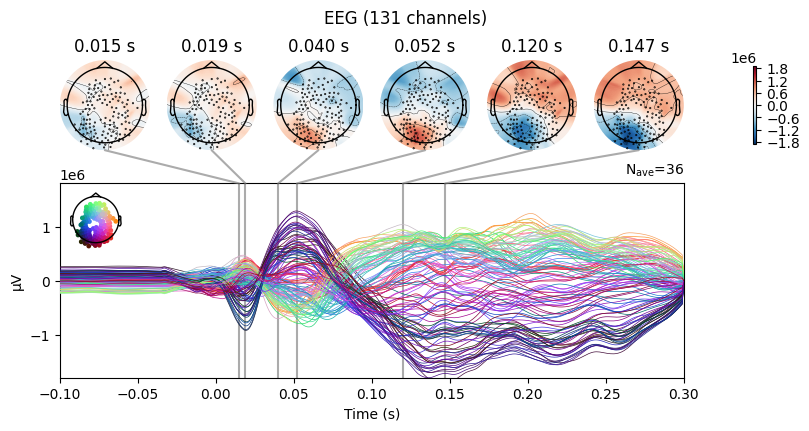

No projector specified for this dataset. Please consider the method self.add_proj.


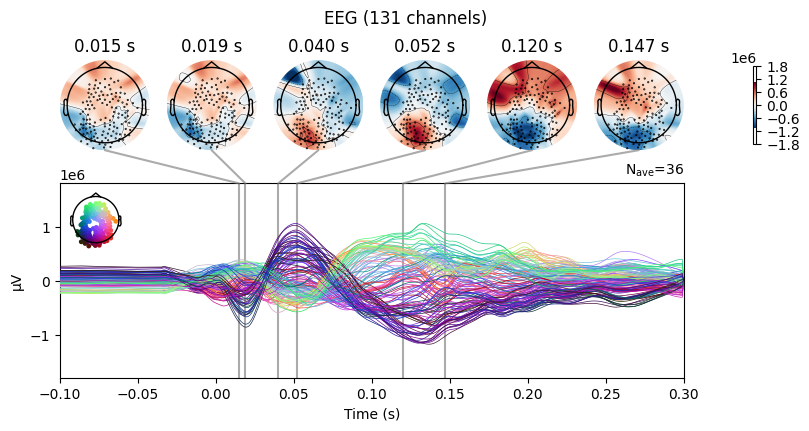

In [24]:
# Read the epoched data from a .fif file
epoched = mne.read_epochs('example_epoched.fif', verbose=False)

# Compute the average evoked response from the epoched data
evoked = epoched.average()

# Find the index corresponding to the time -0.1 seconds
time_start = np.where(evoked.times == -0.1)[0][0]

# Find the index corresponding to the time 0.3 seconds
time_end = np.where(evoked.times == 0.3)[0][0]

# Load data from a pickle file
with open(fit_file, 'rb') as f:
    data = pickle.load(f)

# Create a copy of the evoked data for simulation
simulation = evoked.copy()

# Replace the simulation data in the time range from time_start to time_end with the EEG testing data
simulation.data[:, time_start:time_end] = data.trainingStats.outputs['eeg_testing']

# Find peak locations in specified time windows and store them
ch, peak_locs1 = simulation.get_peak(ch_type='eeg', tmin=-0.05, tmax=0.015)
ch, peak_locs2 = simulation.get_peak(ch_type='eeg', tmin=0.015, tmax=0.03)
ch, peak_locs3 = simulation.get_peak(ch_type='eeg', tmin=0.03, tmax=0.04)
ch, peak_locs4 = simulation.get_peak(ch_type='eeg', tmin=0.04, tmax=0.06)
ch, peak_locs5 = simulation.get_peak(ch_type='eeg', tmin=0.08, tmax=0.12)
ch, peak_locs6 = simulation.get_peak(ch_type='eeg', tmin=0.12, tmax=0.2)

# Set the y-axis limits for plotting
ymin = -1.8e6
ymax = 1.8e6

# Define plotting arguments with x and y limits
ts_args = dict(xlim=[-0.1, 0.3], ylim=dict(eeg=[ymin, ymax]))

# List of peak locations to highlight in the plot
times = [peak_locs1, peak_locs2, peak_locs3, peak_locs4, peak_locs5, peak_locs6]

# Plot the simulation data with specified arguments and peak times
simulation_st = simulation.plot_joint(ts_args=ts_args, times=times)

# Create a copy of the evoked data for lesion simulation
lesion = evoked.copy()

# Replace the lesion data in the time range from time_start to time_end with the new EEG data
lesion.data[:, time_start:time_end] = new_eeg

# Plot the lesion data with specified arguments and peak times
lesion_st = lesion.plot_joint(ts_args=ts_args, times=times)


Plot the Global Mean Field Power before and after the virtual dissection

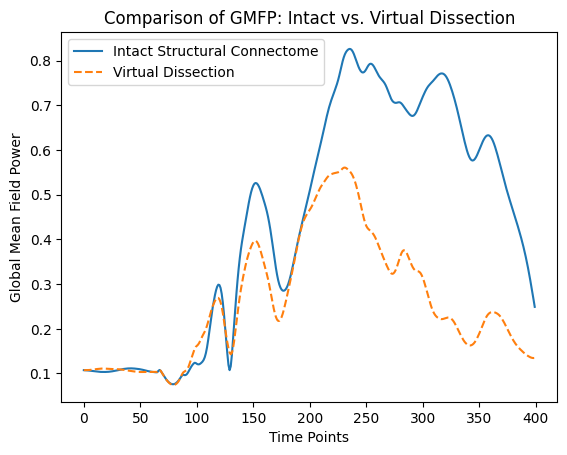

In [29]:
# Plot the standard deviation of the EEG testing data across the time dimension
plt.plot(np.std(data.trainingStats.outputs['eeg_testing'], axis=0), label='Intact Structural Connectome')

# Plot the standard deviation of the new EEG data (after virtual dissection) across the time dimension
plt.plot(np.std(new_eeg, axis=0), label='Virtual Dissection', linestyle='--')

# Add labels and title
plt.xlabel('Time Points')
plt.ylabel('Global Mean Field Power')
plt.title('Comparison of GMFP: Intact vs. Virtual Dissection')
plt.legend()

# Show the plot
plt.show()
